### Project Libraries

In [82]:
import matplotlib.pyplot as plt
import scipy.stats as stats
import statsmodels.api as sm
import seaborn as sns
import pandas as pd

### Reading the data

In [83]:
df = pd.read_csv(r"../data/boavizta-data-us.csv")

### Showcasing some useful information for better understanding of the data

In [84]:
df.head(3)

,manufacturer,name,category,subcategory,gwp_total,gwp_use_ratio,yearly_tec,lifetime,use_location,report_date,...,added_date,add_method,gwp_transport_ratio,gwp_eol_ratio,gwp_electronics_ratio,gwp_battery_ratio,gwp_hdd_ratio,gwp_ssd_ratio,gwp_othercomponents_ratio,comment
0,Apple,13-inch MacBook Air (M1 CPU) 256GB - 2020,Workplace,Laptop,161.0,0.15,NaN,3.0,WW,November 2020,...,27-05-2022,Manual,0.08,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Apple,13-inch MacBook Air (M1 CPU) 512GB - 2020,Workplace,Laptop,181.0,0.15,NaN,3.0,WW,November 2020,...,27-05-2022,Manual,0.08,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Apple,13-inch MacBook Air with Retina display (1.1GH...,Workplace,Laptop,174.0,0.15,NaN,3.0,WW,March 2020,...,01-11-2020,Initial Parsing,0.07,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [85]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1226 entries, 0 to 1225
Data columns (total 32 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   manufacturer               1226 non-null   object 
 1   name                       1226 non-null   object 
 2   category                   1226 non-null   object 
 3   subcategory                1226 non-null   object 
 4   gwp_total                  1226 non-null   float64
 5   gwp_use_ratio              1151 non-null   float64
 6   yearly_tec                 734 non-null    float64
 7   lifetime                   1193 non-null   float64
 8   use_location               1113 non-null   object 
 9   report_date                1211 non-null   object 
 10  sources                    1226 non-null   object 
 11  sources_hash               1226 non-null   object 
 12  gwp_error_ratio            1022 non-null   float64
 13  gwp_manufacturing_ratio    757 non-null    float

In [86]:
df.columns

Index(['manufacturer', 'name', 'category', 'subcategory', 'gwp_total',
       'gwp_use_ratio', 'yearly_tec', 'lifetime', 'use_location',
       'report_date', 'sources', 'sources_hash', 'gwp_error_ratio',
       'gwp_manufacturing_ratio', 'weight', 'assembly_location', 'screen_size',
       'server_type', 'hard_drive', 'memory', 'number_cpu', 'height',
       'added_date', 'add_method', 'gwp_transport_ratio', 'gwp_eol_ratio',
       'gwp_electronics_ratio', 'gwp_battery_ratio', 'gwp_hdd_ratio',
       'gwp_ssd_ratio', 'gwp_othercomponents_ratio', 'comment'],
      dtype='object')

### Cleaning the data
1. Dropping some columns that will not be used for the analysis

In [87]:
df.drop(columns = ['sources', 'server_type', 'hard_drive', 'memory', 'number_cpu', 'height', 'added_date', 'add_method'], inplace=True)

In [88]:
df.columns

Index(['manufacturer', 'name', 'category', 'subcategory', 'gwp_total',
       'gwp_use_ratio', 'yearly_tec', 'lifetime', 'use_location',
       'report_date', 'sources_hash', 'gwp_error_ratio',
       'gwp_manufacturing_ratio', 'weight', 'assembly_location', 'screen_size',
       'gwp_transport_ratio', 'gwp_eol_ratio', 'gwp_electronics_ratio',
       'gwp_battery_ratio', 'gwp_hdd_ratio', 'gwp_ssd_ratio',
       'gwp_othercomponents_ratio', 'comment'],
      dtype='object')

## MUNICIPALITIES (City Halls and Government Agencies)
- Focus: Help cities use hardware lifecycle data to analyze emissions, plan equipment upgrades, and forecast e-waste.

#### The function bellow is being used to evaluate the Strength of the tests. 👇

In [89]:
def evaluating_strength(correlation_coefficient):
    abs_r = abs(correlation_coefficient)
    if correlation_coefficient == 0:
        return "No correlation"
    elif 0 < abs_r < 0.3:
        return "Weak correlation (linear relationship is very weak or negligible)"
    elif 0.3 <= abs_r < 0.5:
        return "Moderate correlation"
    elif 0.5 <= abs_r < 0.7:
        return "Strong correlation"
    elif 0.7 <= abs_r < 1:
        return "Very strong correlation"
    elif abs_r == 1:
        return "Perfect correlation"
    else:
        return "Invalid value for r"

| Hypothesis                                                                | Variables(s) Involved               | Variable Types         | Tests                  |
|---------------------------------------------------------------------------|-------------------------------------|------------------------|-------------------------|
| (H1) Devices with shorter lifetimes contribute to higher yearly emissions | `lifetime`, `gwp_use_ratio`,`gwp_total` | Continuous/ Continuous |Pearson correlation test |

- Handling with missing values:
    * Fill with devices subcategories;
    * Fill with devices categories (If still missing)
    * Drop (in case values still missing)

In [90]:
from scipy.stats import pearsonr, spearmanr

# Fill missing values with subcategory averages
df['lifetime'] = df['lifetime'].fillna(df.groupby('subcategory')['lifetime'].transform('mean'))
df['gwp_total'] = df['gwp_total'].fillna(df.groupby('subcategory')['gwp_total'].transform('mean'))
df['gwp_use_ratio'] = df['gwp_use_ratio'].fillna(df.groupby('subcategory')['gwp_use_ratio'].transform('mean'))

# In case any values are still missing, fallback to category-level average
df['lifetime'] = df['lifetime'].fillna(df.groupby('category')['lifetime'].transform('mean'))
df['gwp_total'] = df['gwp_total'].fillna(df.groupby('category')['gwp_total'].transform('mean'))
df['gwp_use_ratio'] = df['gwp_use_ratio'].fillna(df.groupby('category')['gwp_use_ratio'].transform('mean'))

# Final drop of rows where values are still missing (just in case)
df_clean = df[['lifetime', 'gwp_total', 'gwp_use_ratio']].dropna()

# Pearson: lifetime vs gwp_total
pearson_corr, pearson_p = pearsonr(df_clean['lifetime'], df_clean['gwp_total'])

# Spearman: lifetime vs gwp_use_ratio
spearman_corr, spearman_p = spearmanr(df_clean['lifetime'], df_clean['gwp_use_ratio'])

# Results
print(f"Pearson correlation (lifetime vs gwp_total): {pearson_corr:.3f} (p={pearson_p:.3f})")
print(f"Spearman correlation (lifetime vs gwp_use_ratio): {spearman_corr:.3f} (p={spearman_p:.3f})")

Pearson correlation (lifetime vs gwp_total): 0.129 (p=0.000)
Spearman correlation (lifetime vs gwp_use_ratio): 0.216 (p=0.000)


#### Pearson interpretation and analysis: Correlating lifetime with Total GHG emissions
- Pearson R = 0.129
    - Indicates a weak positive linear correlation: as device lifetime increases, the total GHG emissions slightly increase—but the relationship is very weak.

- P-value = 0.000
    - Since p < α (0.05), this result is statistically significant. We reject the null hypothesis, meaning the observed relationship is unlikely due to chance, even though the effect size is small.

#### Spearman interpretation and analysis: Correlating lifetime with GHG emissions during usage period
- Spearman R = 0.216
    - Shows a weak positive monotonic correlation: devices with longer lifetimes tend to have a higher share of emissions from the use phase, but again, the strength of the relationship is low.

- P-value = 0.000
    - With p < α (0.05), the result is statistically significant, and we reject the null hypothesis. There is enough evidence to support a monotonic association between lifetime and use-phase emissions ratio.

#### Pearson Correlation Plot: lifetime vs gwp_use_ratio

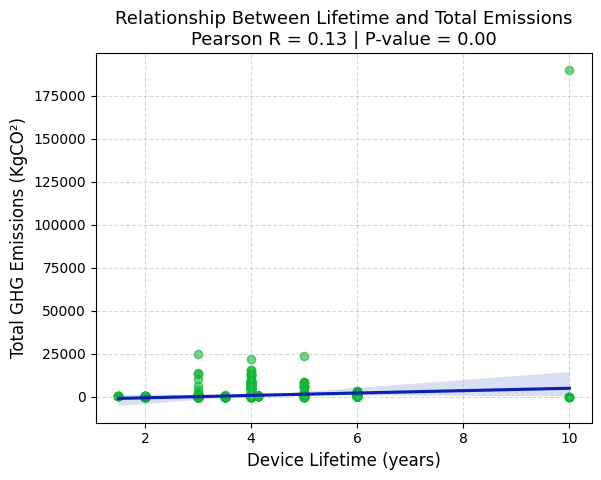

In [91]:
r1, p1 = pearsonr(df_clean['lifetime'], df_clean['gwp_total'])

sns.regplot(x='lifetime', y='gwp_total', data=df_clean,
            line_kws={'color': '#0922AF'},
            scatter_kws={'alpha': 0.6, 'color': '#13b636'})

plt.title(f'Relationship Between Lifetime and Total Emissions\nPearson R = {r1:.2f} | P-value = {p1:.2f}', fontsize=13)
plt.xlabel('Device Lifetime (years)', fontsize=12)
plt.ylabel('Total GHG Emissions (KgCO²)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

#### Spearman Correlation Plot: lifetime vs gwp_use_ratio

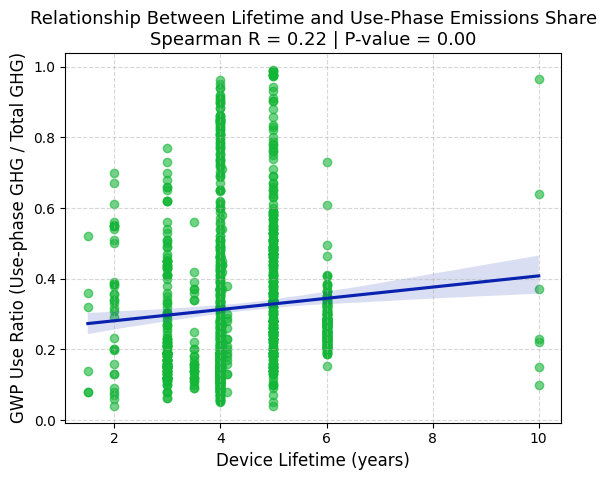

In [92]:
# Spearman correlation
r2, p2 = spearmanr(df_clean['lifetime'], df_clean['gwp_use_ratio'])

sns.regplot(x='lifetime', y='gwp_use_ratio', data=df_clean,
            line_kws={'color': "#0922AF"},
            scatter_kws={'alpha': 0.6, 'color': "#13b636"})

plt.title(f'Relationship Between Lifetime and Use-Phase Emissions Share\nSpearman R = {r2:.2f} | P-value = {p2:.2f}', fontsize=13)
plt.xlabel('Device Lifetime (years)', fontsize=12)
plt.ylabel('GWP Use Ratio (Use-phase GHG / Total GHG)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

BUILD THE CONCLUSION AND SUGGESTION FOR MUNICIPALITIES SOLVE THEIR PROBLEMS AND ALSO TAKE ADVANTAGE OF THE RESULTS SOMEHOW.

| Hypothesis                                                                | Variables(s) Involved               | Variable Types         | Tests                  |
|---------------------------------------------------------------------------|-------------------------------------|------------------------|-------------------------|
| (H2) Workplace devices have higher total weight than Home and Datacenter devices combined.| `weight`, `category` | Nominal/ Continuous |ANOVA |

- Checking if there's any null value is those variables

In [93]:
x = df['category'].isna().sum()
xx = df['weight'].isna().sum()
print(x, xx)

0 191


In [94]:
from scipy.stats import f_oneway

# 1. Fill missing values in 'weight' using group mean by 'category'
df['weight'] = df['weight'].fillna(df.groupby('category')['weight'].transform('mean'))
df['weight'] = df['weight'].fillna(df.groupby('subcategory')['weight'].transform('mean'))
# 2. Extract weights for each group
home_weights = df[df['category'] == 'Home']['weight']
datacenter_weights = df[df['category'] == 'Datacenter']['weight']
workplace_weights = df[df['category'] == 'Workplace']['weight']

# 3. Perform one-way ANOVA
anova_result = f_oneway(home_weights, datacenter_weights, workplace_weights)

# 4. Show results
f_stats = anova_result.statistic
p_value = anova_result.pvalue
print(f"ANOVA F-statistic: {f_stats:.4f}")
print(f"ANOVA p-value: {p_value:.4f}")

ANOVA F-statistic: 287.4017
ANOVA p-value: 0.0000


In [95]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

tukey = pairwise_tukeyhsd(endog=df['weight'], groups=df['category'], alpha=0.05)
print(tukey.summary())

     Multiple Comparison of Means - Tukey HSD, FWER=0.05     
  group1     group2  meandiff p-adj   lower    upper   reject
-------------------------------------------------------------
Datacenter      Home -20.9248    0.0 -23.6398 -18.2097   True
Datacenter Workplace -17.4437    0.0 -19.1879 -15.6994   True
      Home Workplace   3.4811 0.0005   1.3144   5.6479   True
-------------------------------------------------------------


In [96]:
mean_weights = df.groupby('category')['weight'].mean()

print("Average weight per category:")
print(mean_weights)

Average weight per category:
category
Datacenter    21.794492
Home           0.869720
Workplace      4.350841
Name: weight, dtype: float64


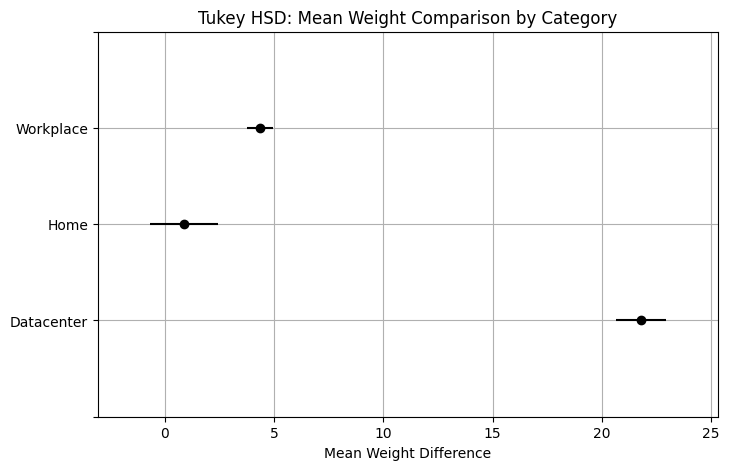

In [97]:

# Plotting Tukey HSD results
fig = tukey.plot_simultaneous(figsize=(8, 5))
plt.title('Tukey HSD: Mean Weight Comparison by Category')
plt.xlabel('Mean Weight Difference')
plt.grid(True)
plt.show()

- #### ANOVA interpretation and analysis: Correlating the weights per category groups

    F-statistic: 286.30

    P-value: 0.0000

- Interpretation:

    - The average weight of Datacenter devices (21.79) is much higher than the average weights of Home (0.69) and Workplace (4.14) devices individually.

    - The combined average of Home and Workplace devices is:
0.69 + 4.14 = 4.83

    - Comparing Datacenter to this combined average:
21.79 / 4.83 ≈ 4.5

The average weight of Datacenter devices is approximately 4.5 times greater than the combined average weight of Home and Workplace devices.

This highlights a substantial difference in device weights, with Datacenter devices being significantly heavier than both Home and Workplace categories.

This reinforces the Tukey HSD results where all pairwise differences were statistically significant, confirming that the Datacenter category is the heaviest group by a wide margin.


| Hypothesis                                                                | Variables(s) Involved               | Variable Types         | Tests                  |
|---------------------------------------------------------------------------|-------------------------------------|------------------------|-------------------------|
| (H3) There is a significant relationship between device lifetime (in years) and its classification as having a sustainable lifetime, based on a minimum durability threshold of 5 years | `lifetime`, `sustainable_lifetime` | Continuous / Binary |Point-Biserial |

In [98]:
# Define threshold for environmentally sustainable lifetime (in years)
SUSTAINABLE_LIFETIME_YEARS = 5

# Create binary variable: 1 if device meets or exceeds threshold, else 0
df['sustainable_lifetime'] = df['lifetime'].apply(lambda x: 1 if x >= SUSTAINABLE_LIFETIME_YEARS else 0)

# Optional: display value counts to verify
print(df['sustainable_lifetime'].value_counts())


sustainable_lifetime
0    737
1    489
Name: count, dtype: int64


In [99]:
from scipy.stats import pointbiserialr

# Run point-biserial correlation
corr, p_value = pointbiserialr(df['sustainable_lifetime'], df['lifetime'])

print(f"Point-biserial correlation: {corr:.4f}")
print(f"P-value: {p_value:.4f}")

Point-biserial correlation: 0.8018
P-value: 0.0000


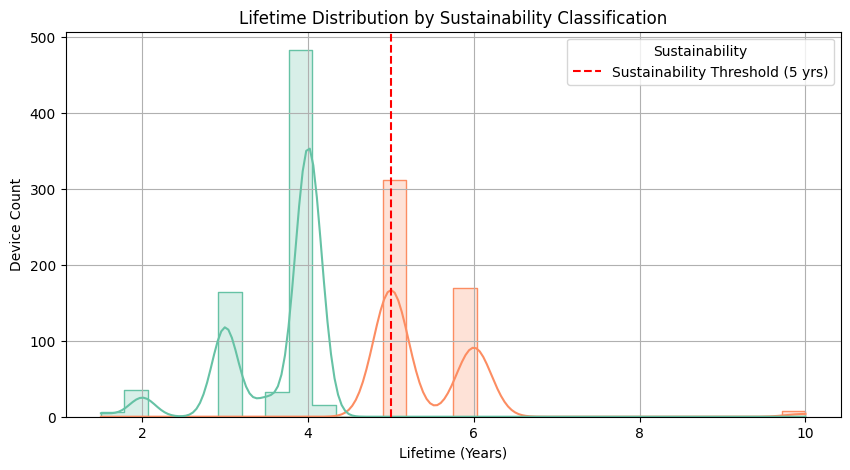

In [102]:
# Histogram comparing both groups
plt.figure(figsize=(10, 5))
sns.histplot(data=df, x='lifetime', hue='sustainable_lifetime', bins=30, kde=True, palette='Set2', element='step')
plt.axvline(5, color='red', linestyle='--', label='Sustainability Threshold (5 yrs)')
plt.title('Lifetime Distribution by Sustainability Classification')
plt.xlabel('Lifetime (Years)')
plt.ylabel('Device Count')
plt.legend(title='Sustainability')
plt.grid(True)
plt.show()

#### Point-Biserial Interpretation and Analysis: Correlating device lifetime and sustainable classification

    Correlation coefficient: 0.8018

    P-value: 0.0000

- Interpretation:

    - Devices were classified as sustainable if their lifetime was greater than or equal to 5 years (sustainable_lifetime = 1), and not sustainable if below that threshold (sustainable_lifetime = 0).

        - Among all devices:

            489 devices (≈40%) met the sustainable threshold.

            737 devices (≈60%) did not meet this standard.

    - The point-biserial correlation of 0.80 indicates a very strong positive relationship between a device's actual lifetime and its sustainable classification. This means that as device lifetime increases, the likelihood of it being considered environmentally sustainable increases sharply.

    - The p-value of 0.0000 confirms that this correlation is statistically significant at any conventional significance level (e.g., α = 0.05). 
    
        __We reject the null hypothesis, affirming a meaningful relationship between the variables__

    - A 5-year durability threshold provides a strong environmental benchmark. Municipalities can embed this into procurement standards and local legislation to reduce landfill waste and improve resource efficiency. It also encourages partnerships with manufacturers for recycling, refurbishment, and take-back programs, supporting a more circular electronics economy.

    